# APS 2 - Reconhecimento de Padrões
## Dataset = Danilo

### Importações

In [27]:
import numpy as np
import os

from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.signal import welch
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,f1_score)
from scipy import signal
import matplotlib.pyplot as plt

### Filtros

In [28]:


def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=200, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

## Carregando o Dataset

In [29]:
caminhos = [os.path.join("src", nome) for nome in os.listdir("src")]
print(caminhos)

['src/1_EMG_Danilo_02-12-2019_201601.npy', 'src/1_EMG_Danilo_02-12-2019_201433.npy', 'src/1_EMG_Danilo_02-12-2019_201252.npy']


In [30]:
dataset = [np.load(gesture) for gesture in caminhos]
dataset = np.array(dataset)

dataset = dataset.swapaxes(2,3)
dataset = dataset.swapaxes(0,2)
dataset = dataset.reshape(4,5, 3*2000)
dataset = dataset.swapaxes(0,1)
print(dataset.shape)


(5, 4, 6000)


#### Após o carregamento do dataset, foi realizado a concatenação das tentativas com os dados de cada coleta, resultando no shape:


#### (Gesto x eletrodos x dados)

## Classificador

In [31]:
def vaiSVC(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, shuffle=True)


    for kernel in ['rbf']:#, 'linear']:
        for gamma in [0.001, 0.01, 0.1]:
            for C in [1, 10, 100, 1000]:
                classificador = []
                classificador = svm.SVC(gamma=gamma, C=C, kernel=kernel).fit(X_train, y_train)
                print('acuracia:', (classificador.score(X_test, y_test)) * 100, 'kernel:', kernel, 'gamma:', gamma, 'C:', C)
            


## Filtragem e Plotagem

In [32]:

def filtering (dataset):
    
    
    for i in range(dataset.shape[1]):
        plt.plot(dataset[0,i,:])
    plt.show()
    data_filtered = []
    #print(dataset.shape[i])
    print(dataset.shape)
    
    data_filtered = butter_notch(dataset, 60)
    for i in range(data_filtered.shape[1]):
        plt.plot(data_filtered[0,i,:])
    plt.show()
    
    data_filtered = butter_highpass(data_filtered, 5)
    for i in range(data_filtered.shape[1]):
        plt.plot(data_filtered[0,i,:])
    plt.show()
    
    data_filtered = butter_lowpass(data_filtered, 50)
    for i in range(data_filtered.shape[1]):
        plt.plot(data_filtered[0,i,:])
    plt.show()
    
    return data_filtered


### Para diminuir o ruído dos dados foram aplicados os filtros Notch, Highpass e LowPass. 

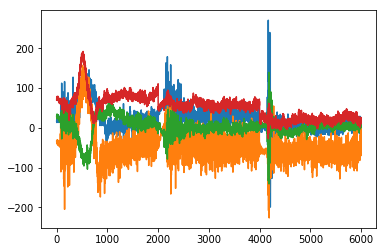

(5, 4, 6000)


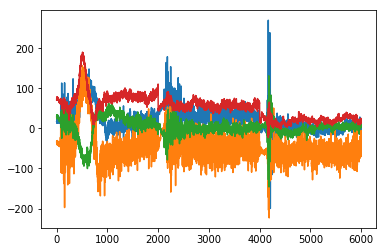

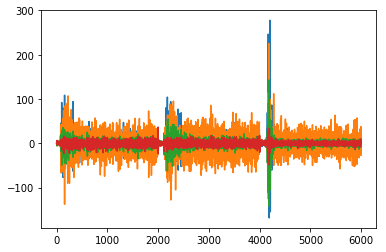

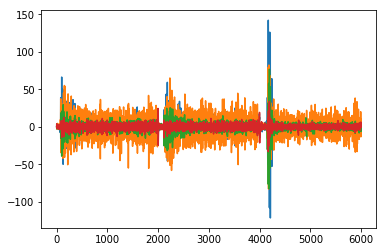

In [33]:
data_filtered = filtering(dataset)

In [34]:
print(data_filtered.shape)

(5, 4, 6000)


## Segmentação
### Na segmentação foram definidos segmentos com o tamanho de 129 e saltos de 20, tendo assim 109 pontos de sobreposição.

In [51]:
salto = 20
segmento = 50
print(data_filtered.shape)
n_win = int((data_filtered.shape[-1] - segmento) / salto) + 1
ids = np.arange(n_win) * salto
x = np.array([data_filtered[:,:,k:(k + segmento)] for k in ids]).transpose(1, 2, 0, 3)
print(x.shape)



(5, 4, 6000)
(5, 4, 298, 50)


## Extração de Características

Para realização da classificação dos movimentos foi necessário extrair características tanto no domínio do tempo quanto no domínio da frequência.

## Domínio do Tempo

#### IEMG

(5, 4, 298)


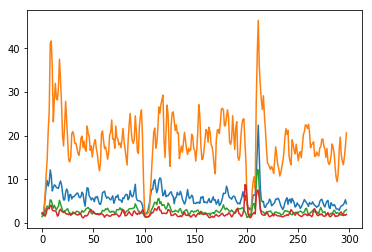

In [56]:

#mod = np.positive(x)
iemg =  np.sum(np.abs(x), axis=-1) / 50
print(iemg.shape)

for i in range(iemg.shape[1]):
    plt.plot(iemg[3,i,:])
plt.show()

#### VAR

(5, 4, 298)


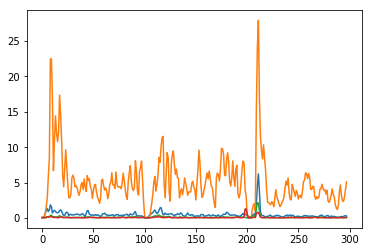

In [57]:
var = np.sum(x ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1)
print(var.shape)

for i in range(var.shape[1]):
    plt.plot(var[3,i,:])
plt.show()

#### RMS

(5, 4, 298)


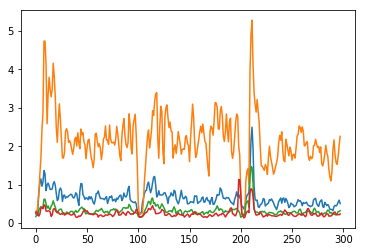

In [58]:
rms = np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1))
print(rms.shape)

for i in range(rms.shape[1]):
    plt.plot(rms[3,i,:])
plt.show()

### Criando Vetor de Labels

Foram concatenadas as características no domínio do tempo com os eletrodos e os segmentos, resultando no shape:
(características , gestos)

In [59]:
lista = [rms] + [var] + [iemg]
lista = np.array(lista)
lista = lista.swapaxes(0,1)
lista = lista.reshape(5,3* 4*298)
lista = lista.swapaxes(0,1)
lista = lista[:,:][:3525]
print(lista.shape)

(3525, 5)


In [60]:
y = np.array([[str(i)] * int(lista.shape[0] / 5) for i in range(5)])
y = y.reshape(y.shape[0] * y.shape[1])
y.shape



(3525,)

In [61]:
vaiSVC(lista,y)

acuracia: 55.60283687943263 kernel: rbf gamma: 0.001 C: 1
acuracia: 61.06382978723405 kernel: rbf gamma: 0.001 C: 10
acuracia: 71.27659574468085 kernel: rbf gamma: 0.001 C: 100
acuracia: 77.58865248226951 kernel: rbf gamma: 0.001 C: 1000
acuracia: 62.97872340425532 kernel: rbf gamma: 0.01 C: 1
acuracia: 76.66666666666667 kernel: rbf gamma: 0.01 C: 10
acuracia: 80.56737588652483 kernel: rbf gamma: 0.01 C: 100
acuracia: 83.04964539007092 kernel: rbf gamma: 0.01 C: 1000
acuracia: 79.9290780141844 kernel: rbf gamma: 0.1 C: 1
acuracia: 82.34042553191489 kernel: rbf gamma: 0.1 C: 10
acuracia: 84.25531914893617 kernel: rbf gamma: 0.1 C: 100
acuracia: 85.1063829787234 kernel: rbf gamma: 0.1 C: 1000


# Domínio da Frequência


In [42]:
from scipy.signal import stft

print(data_filtered.shape)
_, _, w = stft(data_filtered, fs=200, nperseg=256, noverlap=32)
w = w.swapaxes(2,3)
print(w.shape)

(5, 4, 6000)
(5, 4, 28, 129)


#### PSD

In [43]:
def PSD(x):
    return np.sqrt(np.abs(x))

#### FMD

In [44]:
fmd = np.sum(PSD(w), axis=-1) / 2
print(fmd.shape)

(5, 4, 28)


#### MMDF

In [45]:
mmdf = np.sum(np.abs(w), axis=-1) / 2
print(mmdf.shape)

(5, 4, 28)


In [46]:
frelist = [fmd] + [mmdf]
frelist = np.array(frelist)
frelist = frelist.swapaxes(0,1)
frelist = frelist.reshape(5,2*4*28)
frelist = frelist.swapaxes(0,1)
frelist = frelist[:][:220]
print(frelist.shape)



(220, 5)


In [47]:
y2 = np.array([[str(i)] * int(frelist.shape[0] / 5) for i in range(5)])
y2 = y2.reshape(y2.shape[0] * y2.shape[1])
y2.shape


(220,)

In [48]:
vaiSVC(frelist,y2)

acuracia: 59.09090909090909 kernel: rbf gamma: 0.001 C: 1
acuracia: 69.31818181818183 kernel: rbf gamma: 0.001 C: 10
acuracia: 70.45454545454545 kernel: rbf gamma: 0.001 C: 100
acuracia: 65.9090909090909 kernel: rbf gamma: 0.001 C: 1000
acuracia: 71.5909090909091 kernel: rbf gamma: 0.01 C: 1
acuracia: 70.45454545454545 kernel: rbf gamma: 0.01 C: 10
acuracia: 71.5909090909091 kernel: rbf gamma: 0.01 C: 100
acuracia: 71.5909090909091 kernel: rbf gamma: 0.01 C: 1000
acuracia: 43.18181818181818 kernel: rbf gamma: 0.1 C: 1
acuracia: 45.45454545454545 kernel: rbf gamma: 0.1 C: 10
acuracia: 45.45454545454545 kernel: rbf gamma: 0.1 C: 100
acuracia: 45.45454545454545 kernel: rbf gamma: 0.1 C: 1000


# Combinação domínio do tempo e frequência

In [49]:
print(lista.shape)
print(frelist.shape)

X = np.concatenate((lista, frelist), axis=0)
yf = np.concatenate((y2 , y), axis=0)
print(y2.shape, y.shape)
print(yf.shape)
print(X.shape)

(3525, 5)
(220, 5)
(220,) (3525,)
(3745,)
(3745, 5)


In [50]:
vaiSVC(X,yf)

acuracia: 61.94926568758344 kernel: rbf gamma: 0.001 C: 1
acuracia: 74.6328437917223 kernel: rbf gamma: 0.001 C: 10
acuracia: 76.7690253671562 kernel: rbf gamma: 0.001 C: 100
acuracia: 80.77436582109479 kernel: rbf gamma: 0.001 C: 1000
acuracia: 76.50200267022697 kernel: rbf gamma: 0.01 C: 1
acuracia: 82.04272363150868 kernel: rbf gamma: 0.01 C: 10
acuracia: 84.64619492656877 kernel: rbf gamma: 0.01 C: 100
acuracia: 87.98397863818424 kernel: rbf gamma: 0.01 C: 1000
acuracia: 85.64753004005341 kernel: rbf gamma: 0.1 C: 1
acuracia: 88.91855807743659 kernel: rbf gamma: 0.1 C: 10
acuracia: 89.91989319092123 kernel: rbf gamma: 0.1 C: 100
acuracia: 91.45527369826435 kernel: rbf gamma: 0.1 C: 1000
